In [29]:
import pandas as pd
import geopandas as gpd
import cbsodata

In [30]:
# Zoek op welke data beschikbaar is
metadata = pd.DataFrame(cbsodata.get_meta('83765NED', 'DataProperties'))

In [31]:
dfStudenten = pd.read_csv("VerhuisdePersonen15-25.csv", sep = ";")
dfStudenten = dfStudenten.dropna()
dfStudenten = dfStudenten.rename(columns = {"Regio's": "Regio"})
dfStudenten.head()

,Perioden,Regio,Binnen gemeenten verhuisde personen/Naar geslacht en leeftijd (31 december)/Totaal mannen en vrouwen/15 tot 20 jaar (aantal),Binnen gemeenten verhuisde personen/Naar geslacht en leeftijd (31 december)/Totaal mannen en vrouwen/20 tot 25 jaar (aantal),Tussen gemeenten verhuisde personen/Gevestigd in de gemeente/Naar geslacht en leeftijd (31 december)/Totaal mannen en vrouwen/15 tot 20 jaar (aantal),Tussen gemeenten verhuisde personen/Gevestigd in de gemeente/Naar geslacht en leeftijd (31 december)/Totaal mannen en vrouwen/20 tot 25 jaar (aantal),Tussen gemeenten verhuisde personen/Vertrokken uit de gemeente/Naar geslacht en leeftijd (31 december)/Totaal mannen en vrouwen/15 tot 20 jaar (aantal),Tussen gemeenten verhuisde personen/Vertrokken uit de gemeente/Naar geslacht en leeftijd (31 december)/Totaal mannen en vrouwen/20 tot 25 jaar (aantal)
0,2018,Aa en Hunze,50.0,59.0,72.0,178.0,123.0,246.0
1,2018,Aalburg,33.0,49.0,18.0,58.0,31.0,89.0
2,2018,Aalsmeer,71.0,80.0,65.0,154.0,74.0,175.0
3,2018,Aalten,70.0,123.0,31.0,136.0,80.0,134.0
8,2018,Achtkarspelen,85.0,156.0,76.0,159.0,87.0,186.0


In [32]:
geodata_url = "https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json"
gemeentegrenzen = gpd.read_file(geodata_url)

In [33]:
gemeentegrenzen = pd.merge(gemeentegrenzen, dfStudenten,
                           left_on = "statcode", 
                           right_on = "Regio")

C:\Users\simcha\Anaconda3\lib\site-packages\geopandas\plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Text(0.5,1,'Levend geborenen per 1000 inwoners, 2017')

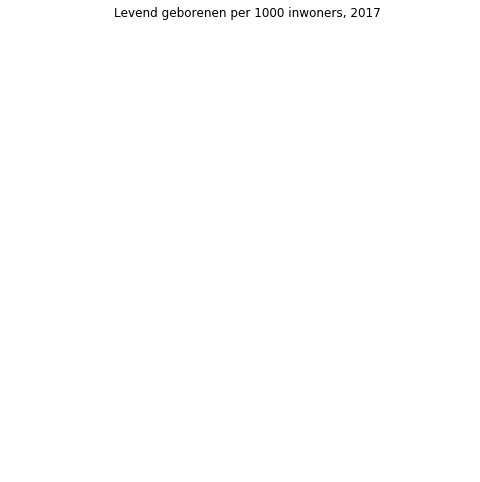

In [34]:
# Maak een thematische kaart
p = gemeentegrenzen.plot(column='Tussen gemeenten verhuisde personen/Vertrokken uit de gemeente/Naar geslacht en leeftijd (31 december)/Totaal mannen en vrouwen/20 tot 25 jaar (aantal)', 
                         figsize = (10,8))
p.axis('off')
p.set_title('Levend geborenen per 1000 inwoners, 2017')